In [3]:
import awswrangler  as wr
import pandas as pd
# import pandas.io.json
import pymysql
import datetime
import json


# load sql
#
sql = '''
with ubl as (
select
from_iso8601_timestamp(json_extract_scalar(user_properties, '$.first_at'))  + interval '9' hour AS first_at
, client_access_time as reg_ts
,  cast( json_extract_scalar ( event_properties , '$.stay_time_seconds') as integer) as stay_time
, case
    when device like 'Web%' then case when device like '%Mobile%'  then 'mobile_web'
                    when device like '%Desktop%' then  'desktop'  end
    when device like 'App%' then 'App'
    else 'unknown' end as device_type
, case when category = 'apply' and object_type = 'plan' then 1 end as apply_plan
 , *
     from moyo_logs.user_behavior_logs
     where 1 = 1
        and date_ymd between '2023-03-10'
--                         and '2023-04-10' -- 나중에 수정 해야함
                and '2023-06-04'
        and from_iso8601_timestamp(json_extract_scalar(user_properties, '$.first_at'))  + interval '9' hour
            is not null
-- limit 1000
-- 23년 3월동안 가입한 유저들이 30일 동안 재방문 가능성
)
, merge as (
select
user_id
, uuid
from ubl
where 1 = 1
    and cast(user_id as double) <> 0
    and user_id is not null
    and first_at is not null
--     and device_type = 'App'
group by 1, 2
order by 1
)
, merge_join as (
select
a.first_at
, a.reg_ts
, a.apply_plan
, b.user_id
, b.uuid
from ubl a
join merge b on a.uuid = b.uuid
)
, lead1 as (
select
user_id
, reg_ts
, lead(reg_ts, 1) over (partition by user_id order by reg_ts) as next_reg_ts
from merge_join
where 1=1
)
,df as (
select
*
, date_diff( 'minute', reg_ts, next_reg_ts) as diff_min
from lead1
)
, user_agg as (
select
user_id
,case when  sum( apply_plan ) >= 1 then 1 else 0 end as apply_plan
, sum( apply_plan) as apply_plan_cnt
from merge_join
where 1=1
    and date(first_at) between date('2023-03-10') and date('2023-04-10')
group by 1
)
, join1 as (
select
a.*
, b.apply_plan
from df a
join  user_agg b on a.user_id = b.user_id
)
, user_agg2 as (
select
User_id
, apply_plan
, max( diff_min ) as max_diff_min
from join1
group by 1,2
)
select 
* 
from user_agg2
'''
# sql_v1 = ''' 
# select *
# from moyo_scraping.mno_scraping_result
# where 1=1
#     and version = 1 
# '''
# sql_v2 = '''
# select *
# from moyo_scraping.mno_scraping_result
# where 1=1

#     and version = 2
# '''
df_v1= wr.athena.read_sql_query(sql=sql, database="moyo_order")

In [4]:
df_v1.head()

,user_id,apply_plan,max_diff_min
0,1538,1,0
1,1860,0,90959
2,2245,1,15908
3,2309,0,58788
4,2443,1,79085


In [12]:
df_v1.dropna(inplace=True)

In [13]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37500 entries, 0 to 37518
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       37500 non-null  Int64
 1   apply_plan    37500 non-null  Int32
 2   max_diff_min  37500 non-null  Int64
dtypes: Int32(1), Int64(2)
memory usage: 1.1 MB


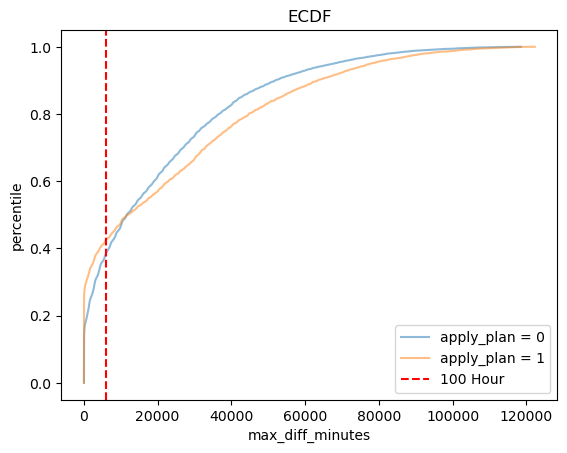

In [26]:
# apply_plan 기준으로 분기 만들어서 max_diff_min 의 ecdf 그려줘 
# ecdf plot 
# Path: Workbook/user_behavier_churn _and_duplicated_auth/user_duplicated_auth.ipynb
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame, and 'dimension' is your categorical variable

for category in df_v1['apply_plan'].unique():
    # Select data for this category
    data = df_v1[df_v1['apply_plan'] == category]

    # Compute ECDF
    x = np.sort(data['max_diff_min'])
    y = np.arange(1, len(x) + 1) / len(x)

    # Plot ECDF
    plt.plot(x, y, label=category, alpha = 0.5)

plt.xlabel('max_diff_minutes')
plt.ylabel('percentile')
plt.axvline(x=6000, color='r', linestyle='--', label='100h')
plt.legend(['apply_plan = 0', 'apply_plan = 1','100 Hour'])
plt.title( 'ECDF')
plt.show()



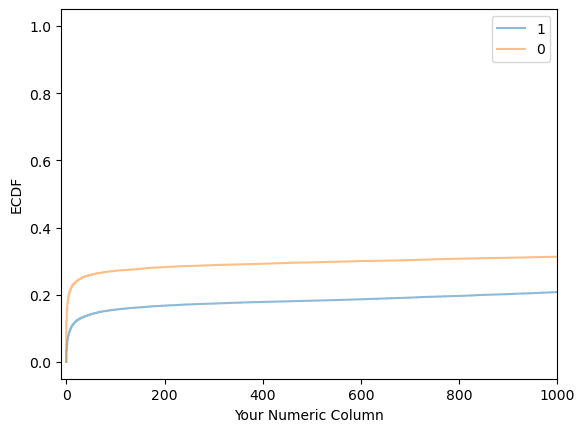

In [16]:
# apply_plan 기준으로 분기 만들어서 max_diff_min 의 ecdf 그려줘 
# ecdf plot 
# Path: Workbook/user_behavier_churn _and_duplicated_auth/user_duplicated_auth.ipynb
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame, and 'dimension' is your categorical variable

for category in df_v1['apply_plan'].unique():
    # Select data for this category
    data = df_v1[df_v1['apply_plan'] == category]

    # Compute ECDF
    x = np.sort(data['max_diff_min'])
    y = np.arange(1, len(x) + 1) / len(x)

    # Plot ECDF
    plt.plot(x, y, label=category, alpha = 0.5)

plt.xlabel('Your Numeric Column')
plt.ylabel('ECDF')
# plt.axvline(x=60, color='r', linestyle='--')
plt.xlim(-10, 1000)
plt.legend()
plt.show()



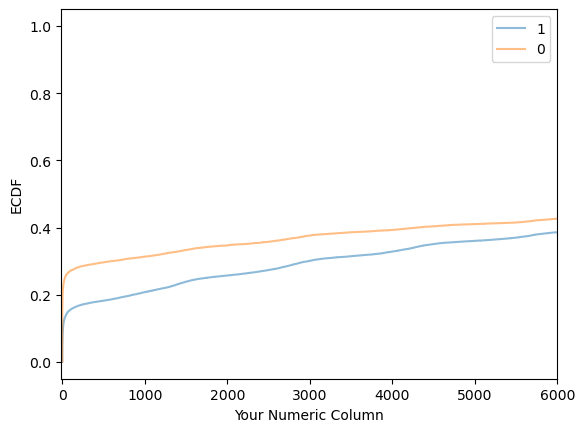

In [17]:
# apply_plan 기준으로 분기 만들어서 max_diff_min 의 ecdf 그려줘 
# ecdf plot 
# Path: Workbook/user_behavier_churn _and_duplicated_auth/user_duplicated_auth.ipynb
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame, and 'dimension' is your categorical variable

for category in df_v1['apply_plan'].unique():
    # Select data for this category
    data = df_v1[df_v1['apply_plan'] == category]

    # Compute ECDF
    x = np.sort(data['max_diff_min'])
    y = np.arange(1, len(x) + 1) / len(x)

    # Plot ECDF
    plt.plot(x, y, label=category, alpha = 0.5)

plt.xlabel('Your Numeric Column')
plt.ylabel('ECDF')
# plt.axvline(x=60, color='r', linestyle='--')
plt.xlim(-10, 6000)
plt.legend()
plt.show()



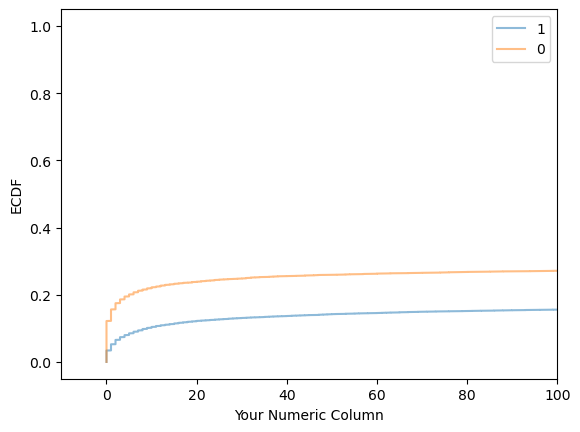

In [19]:
# apply_plan 기준으로 분기 만들어서 max_diff_min 의 ecdf 그려줘 
# ecdf plot 
# Path: Workbook/user_behavier_churn _and_duplicated_auth/user_duplicated_auth.ipynb
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame, and 'dimension' is your categorical variable

for category in df_v1['apply_plan'].unique():
    # Select data for this category
    data = df_v1[df_v1['apply_plan'] == category]

    # Compute ECDF
    x = np.sort(data['max_diff_min'])
    y = np.arange(1, len(x) + 1) / len(x)

    # Plot ECDF
    plt.plot(x, y, label=category, alpha = 0.5)

plt.xlabel('Your Numeric Column')
plt.ylabel('ECDF')
# plt.axvline(x=60, color='r', linestyle='--')
plt.xlim(-10, 100)
plt.legend()
plt.show()



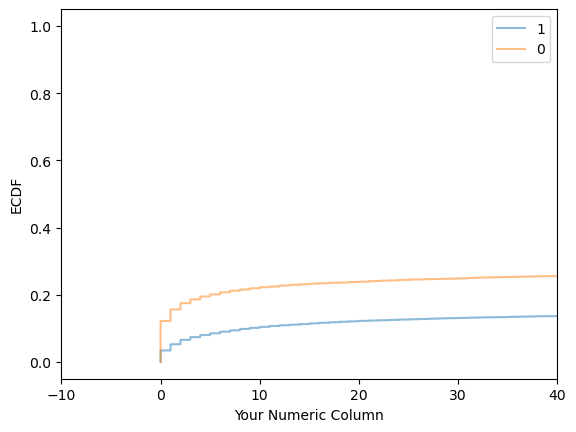

In [20]:
# apply_plan 기준으로 분기 만들어서 max_diff_min 의 ecdf 그려줘 
# ecdf plot 
# Path: Workbook/user_behavier_churn _and_duplicated_auth/user_duplicated_auth.ipynb
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame, and 'dimension' is your categorical variable

for category in df_v1['apply_plan'].unique():
    # Select data for this category
    data = df_v1[df_v1['apply_plan'] == category]

    # Compute ECDF
    x = np.sort(data['max_diff_min'])
    y = np.arange(1, len(x) + 1) / len(x)

    # Plot ECDF
    plt.plot(x, y, label=category, alpha = 0.5)

plt.xlabel('Your Numeric Column')
plt.ylabel('ECDF')
# plt.axvline(x=60, color='r', linestyle='--')
plt.xlim(-10, 40)
plt.legend()
plt.show()

